<a href="https://colab.research.google.com/github/Jasper-Hewitt/final_project_elections/blob/main/Roberta_train_postest_upanddownsample_2epoch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0 Init

## 0-1 Install Dependences

In [1]:
!pip install datasets
!pip install transformers
!pip install --upgrade xlrd
!pip install huggingface_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! rm -rf output

## 0-2 Parameters

In [3]:
number_classes = 2
epoch = 2


model_tokenizer = "hfl/chinese-roberta-wwm-ext"
model_pretran = "hfl/chinese-roberta-wwm-ext" 
model_output = "Jiabo/Roberta_Chinese_sentiment"


# 1 Load Data and tokenize

### 1.1 Load dataset

In [4]:
! wget -nc https://github.com/Jasper-Hewitt/final_project_elections/blob/main/data/train/usual_train.xlsx?raw=true
! wget -nc https://github.com/Jasper-Hewitt/final_project_elections/blob/main/data/eval/usual_eval_labeled.xlsx?raw=true
! wget -nc https://github.com/Jasper-Hewitt/final_project_elections/blob/main/data/test/df_combined_trad.xlsx?raw=true

File ‘usual_train.xlsx?raw=true’ already there; not retrieving.

File ‘usual_eval_labeled.xlsx?raw=true’ already there; not retrieving.

File ‘df_combined_trad.xlsx?raw=true’ already there; not retrieving.



In [5]:
map_dict = dict()

if number_classes == 6:
    map_dict['angry']=0
    map_dict['happy']=1
    map_dict['neutral']=2
    map_dict['surprise']=3
    map_dict['sad']=4
    map_dict['fear']=5
else:
    map_dict['angry']=0 #neg
    map_dict['happy']=1 #pos
    map_dict['neutral']=3 #ignore
    map_dict['surprise']=3 #ignore
    map_dict['sad']=0 #neg
    map_dict['fear']=0 #neg
    map_dict['negative']=0 #neg
    map_dict['positive']=1 #pos


len(map_dict)

8

In [6]:
# ['neutral', 'fear', 'anger', 'posiitive', 'positive', 'suprise',
#       'surprise', 'sad', 'negative', 'angry', 'happy', 'neural']


ici_map_dict = dict()

if number_classes == 6:

    ici_map_dict['angry']=0
    ici_map_dict['anger']=0
    ici_map_dict['positive']=1
    ici_map_dict['posiitive']=1
    ici_map_dict['happy']=1
    ici_map_dict['neutral']=2
    ici_map_dict['neural']=2
    ici_map_dict['surprise']=3
    ici_map_dict['suprise']=3
    ici_map_dict['sad']=4
    ici_map_dict['negative']=4
    ici_map_dict['fear']=5
else:
    ici_map_dict['positive']=1 #pos
#    ici_map_dict['posiitive']=1 #pos
#    ici_map_dict['neutral']=3 #ignore
#    ici_map_dict['surprise']=3 #ignore
    ici_map_dict['negative']=0 #neg
 

len(ici_map_dict)

2

In [7]:
import pandas as pd

training_pd = pd.read_excel('/content/usual_train.xlsx?raw=true',
                            names=['text', 'label'])

training_pd['label'] = training_pd['label'].map(map_dict).astype('int')
training_pd.head(5)

,text,label
1,气死姐姐了，快二是阵亡了吗，尼玛，一个半小时过去了也没上车,0
2,妞妞啊，今天又承办了一个发文登记文号是126~嘻~么么哒~晚安哟,1
3,这里还值得注意另一个事实，就是张鞠存原有一个东溪草堂为其读书处。,3
4,这在前华约国家(尤其是东德)使用R-73的首次联合演习期间，被一些北约组织的飞行员所证实。,3
5,TinyThief上wii了？！,3


In [8]:
if number_classes == 6:
     pass
else:
    training_pd = training_pd[training_pd['label'] != 3]

training_pd = training_pd.dropna().reset_index(drop=True)

In [9]:
training_pd['label'].value_counts()

0    14553
1     5378
Name: label, dtype: int64

### 1.1.1 get more positive data

In [10]:
#usual_test
! wget -nc https://github.com/Jasper-Hewitt/final_project_elections/blob/main/data/test/usual_test_labeled.xls?raw=true

File ‘usual_test_labeled.xls?raw=true’ already there; not retrieving.



In [11]:
#get data from usual_test
tezt_pd = pd.read_excel('/content/usual_test_labeled.xls?raw=true',
                            names=['number','text', 'label'])

tezt_pd['label'] = tezt_pd['label'].map(map_dict).astype('int')
tezt_pd['label'].value_counts()

0    2618
3    1364
1    1018
Name: label, dtype: int64

In [12]:
tezt_pd=tezt_pd[['text', 'label']]
tezt_pd = tezt_pd[tezt_pd['label'] != 3]
tezt_pd = tezt_pd.dropna().reset_index(drop=True)
tezt_pd['label'].value_counts()

0    2618
1    1018
Name: label, dtype: int64

In [13]:
pos_test_pd = tezt_pd.loc[tezt_pd['label'] == 1]  
pos_test_pd['label'].value_counts()

1    1018
Name: label, dtype: int64

In [14]:
#add positive data to training_pd
training_pd=training_pd.append(pos_test_pd)
training_pd['label'].value_counts()

0    14553
1     6396
Name: label, dtype: int64

In [15]:
#delete duplicate rows
training_pd = training_pd.drop_duplicates(['text'])

In [16]:
training_pd['label'].value_counts()

0    13917
1     6369
Name: label, dtype: int64

In [17]:
#upsize minority class (positive). You can consider turning this cell off. With the current data (df_sample.xlsx) this will lead to a 0.840 accuracy. 
from collections import Counter
from sklearn.utils import resample

# Separate majority and minority classes
negative = training_pd[training_pd['label'] == 0]
positive = training_pd[training_pd['label'] == 1]

# Downsample majority class
negative_downsampled = resample(negative, 
                                replace=False,    # sample without replacement
                                n_samples=10000,  # to match minority class
                                random_state=123) # reproducible results

# Upsample minority class
positive_upsampled = resample(positive, 
                              replace=True,     # sample with replacement
                              n_samples=10000,  # to match majority class
                              random_state=123) # reproducible results

# Combine upsampled minority class with downsampled majority class
upsampled = pd.concat([negative_downsampled, positive_upsampled])

# Display new class counts
print(upsampled['label'].value_counts())


0    10000
1    10000
Name: label, dtype: int64


In [18]:
training_pd = upsampled

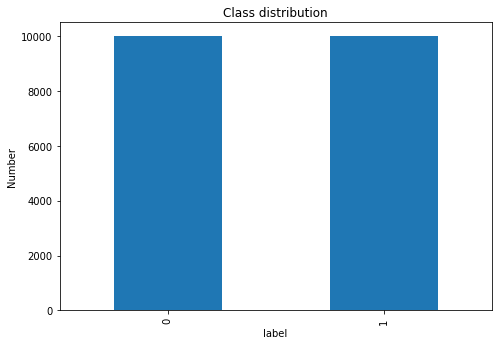

In [19]:
import matplotlib.pyplot as plt

counts = training_pd.groupby("label").size()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

# Create a bar plot
counts.plot(kind="bar")

# Show the plot
ax.set_ylabel('Classes')
ax.set_ylabel('Number')
ax.set_title('Class distribution')
plt.show()

### 1.1.1 (end) code continued

In [20]:
evaluation_pd = pd.read_excel('/content/usual_eval_labeled.xlsx?raw=true')[['文本','情绪标签']] 
evaluation_pd = evaluation_pd.rename(columns={'文本': 'text', '情绪标签': 'label'})

evaluation_pd['label'] = evaluation_pd['label'].map(map_dict).astype('int')
evaluation_pd.head(5)

/usr/local/lib/python3.8/dist-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


,text,label
0,所以注定我这辈子是做不了商人妈蛋,0
1,无论是心情多么低沉的夜晚，天光大亮后都是崭新的开始。,1
2,帽子怎么就变绿色幸好只是试一下,0
3,不想当个好人，好人的背后有多少的心酸害怕喝醉酒的人，害怕他们做出无法挽回的事情是真的会醉么？...,3
4,一种爱是你可以为她去死；还有一种爱是得为你爱的人好好活着。,1


In [21]:
if number_classes == 6:
    pass
else:
    evaluation_pd = evaluation_pd[evaluation_pd['label'] != 3]

evaluation_pd = evaluation_pd.dropna().reset_index(drop=True)

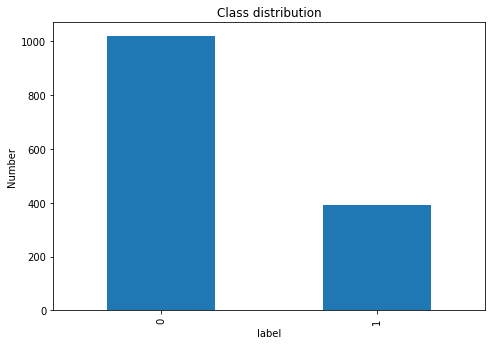

In [22]:
import matplotlib.pyplot as plt

counts = evaluation_pd.groupby("label").size()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

# Create a bar plot
counts.plot(kind="bar")

# Show the plot
ax.set_ylabel('Classes')
ax.set_ylabel('Number')
ax.set_title('Class distribution')
plt.show()

In [23]:
testing_pd = pd.read_excel('/content/df_combined_trad.xlsx?raw=true')

testing_pd = testing_pd[['text', 'cya_check_3']]
testing_pd = testing_pd.rename(columns={'cya_check_3':'label'})
testing_pd = testing_pd[(testing_pd['label'] == 'negative') | (testing_pd['label'] == 'positive')]


# align labels
# testing_pd['label'].unique()
testing_pd['label'] = testing_pd['label'].str.lower()
testing_pd['label'] = testing_pd['label'].str.split(' ', 0, expand = True)[0]
testing_pd['label'] = testing_pd['label'].str.split(',', 0, expand = True)[0]
testing_pd['label'] = testing_pd['label'].map(ici_map_dict).astype('int')

testing_pd.shape

(265, 2)

In [24]:
testing_pd = testing_pd[(testing_pd['label'] == 0) | (testing_pd['label'] == 1)]

testing_pd = testing_pd[~testing_pd['text'].str.contains('a href', regex=True)]

# TODO: we should remove non-Chinese characters in 'text column'
import re
html_pattern = "<(?:\"[^\"]*\"['\"]*|'[^']*'['\"]*|[^'\">])+>"
http_pattern = "http\S+"
image_pattern = "<img\s[^>]*?src\s*=\s*['\"]([^'\"]*?)['\"][^>]*?>" 
title_pattern = "[【|《*】|》]"
title_pattern_1 = "(?=【)(.*)(?<=】)"
title_pattern_2 = "(?=《)(.*)(?<=》)"
link_pattern="网页链接"
span_pattern='<span.*?>(.+?)</span>'

#we have to find a way to delete the entire <span> tag. some posts will end up with only 2 or 3 characters after that. We can drop them. 



testing_pd['text'] = testing_pd['text'].replace(span_pattern,'',regex=True).replace(span_pattern,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(http_pattern,'',regex=True).replace(html_pattern,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(image_pattern,'',regex=True).replace(title_pattern_1,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(link_pattern,'',regex=True).replace(html_pattern,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(title_pattern_2,'',regex=True)

if number_classes == 6:
    pass
else:
    testing_pd = testing_pd[testing_pd['label'] != 3]

testing_pd = testing_pd.dropna().reset_index(drop=True)

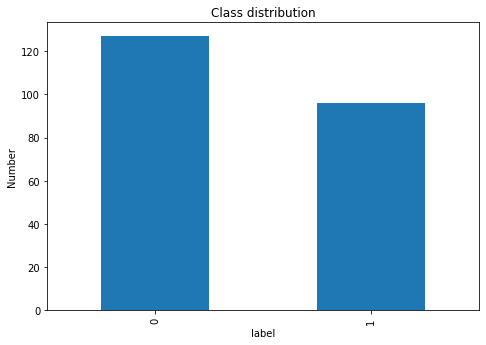

In [25]:
import matplotlib.pyplot as plt

counts = testing_pd.groupby("label").size()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

# Create a bar plot
counts.plot(kind="bar")

# Show the plot
ax.set_ylabel('Classes')
ax.set_ylabel('Number')
ax.set_title('Class distribution')
plt.show()

In [26]:
num_label = len(evaluation_pd['label'].unique())
num_label

2

In [27]:
testing_pd

,text,label
0,国民党台北市长候选人蒋万安的太太石舫亘上周起开始帮忙分摊市场扫街行程，今天上午前往黄国梁资深...,1
1,长期关心台湾少子化问题，8月25日也曾发布“育儿生养政策”的国民党台北市长候选人蒋万安，传出...,1
2,资深媒体人周玉蔻近期大力支持民进党台北市长候选人陈时中，为此多次向国民党候选人蒋万安开炮，还...,0
3,蒋万安称，他是“正蓝军”，呼吁蓝营团结支持。 ​,1
4,日本学者预测，这次台北市长选举，国民党候选人蒋万安可能当选；民进党台北市长候选人陈时中今受访...,1
...,...,...
218,说什么蒋经国不是蒋介石亲生的，蒋介石没有后，纯属扯淡，蒋友柏和蒋介石很像好吗,0
219,国民党台北市议员徐巧芯日前公布民进党台北市长参选人陈时中竞选办公室分机通讯录，名单中竟有许多...,0
220,2022/9/17 周玉蔻攻擊慈濟完再攻擊蔣萬安，蔣應砲火全開回擊，贏回藍營的搖擺選民變色媒...,0
221,资深媒体人周玉蔻日前攻击国民党台北市长候选人蒋万安，指其父绯闻女主角是张淑娟，还在遭按铃申告...,0


In [28]:
from datasets import Dataset, DatasetDict

weibo_dict = {'train' : Dataset.from_pandas(training_pd),
               'eval' : Dataset.from_pandas(evaluation_pd),
               'test' : Dataset.from_pandas(testing_pd)}
              # 'eval' : Dataset.from_pandas(evaluation_pd),

#weibo_dict = {'train' : Dataset.from_pandas(training_pd),
#              'eval' : Dataset.from_pandas(evaluation_pd)}

#weibo_dict = {'eval' : Dataset.from_pandas(evaluation_pd)}

        

weibo_ds = DatasetDict(weibo_dict)

In [29]:
weibo_ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 20000
    })
    eval: Dataset({
        features: ['text', 'label'],
        num_rows: 1410
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 223
    })
})

### 1.2 Data Tokenize by wmmBERT

In [30]:
from transformers import AutoTokenizer

In [31]:
tokenizer = AutoTokenizer.from_pretrained(model_tokenizer)

In [32]:
def tokenize_function(examples):
    return tokenizer(examples["text"], 
                     padding="max_length", 
                     truncation=True, 
                     max_length=500)

tokenized_datasets = weibo_ds.map(tokenize_function, batched=True)

  0%|          | 0/20 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [33]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 20000
    })
    eval: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1410
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 223
    })
})

# 2 Fine-Tuning, benchmarking and visualization

In [34]:
# small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(1000))
# small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1000))
full_train_dataset = tokenized_datasets["train"]
full_eval_dataset = tokenized_datasets["eval"]
full_test_dataset = tokenized_datasets["test"]

## 2.1 Fine-tuning using wmmBERT

In [35]:
from transformers import AutoModelForSequenceClassification


model = AutoModelForSequenceClassification.from_pretrained(model_pretran, 
                                                           num_labels=num_label)

Some weights of the model checkpoint at hfl/chinese-roberta-wwm-ext were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model che

In [36]:
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

<ipython-input-36-e1ee7db0da93>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [37]:
from transformers import TrainingArguments

training_args = TrainingArguments(num_train_epochs=epoch,
                                  output_dir="output")

In [38]:
from transformers import Trainer

trainer = Trainer(
    model=model, 
    args=training_args, 
    train_dataset=full_train_dataset, 
    eval_dataset=full_eval_dataset,
    compute_metrics=compute_metrics,
)

In [39]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 20000
  Num Epochs = 2
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 5000
  Number of trainable parameters = 102269186


Step,Training Loss
500,0.389500
1000,0.326700
1500,0.292500
2000,0.272200
2500,0.251100
3000,0.129100
3500,0.115000
4000,0.112100
4500,0.088700
5000,0.098300


Saving model checkpoint to output/checkpoint-500
Configuration saved in output/checkpoint-500/config.json
Model weights saved in output/checkpoint-500/pytorch_model.bin
Saving model checkpoint to output/checkpoint-1000
Configuration saved in output/checkpoint-1000/config.json
Model weights saved in output/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to output/checkpoint-1500
Configuration saved in output/checkpoint-1500/config.json
Model weights saved in output/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to output/checkpoint-2000
Configuration saved in output/checkpoint-2000/config.json
Model weights saved in output/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to output/checkpoint-2500
Configuration saved in output/checkpoint-2500/config.json
Model weights saved in output/checkpoint-2500/pytorch_model.bin
Saving model checkpoint to output/checkpoint-3000
Configuration saved in output/checkpoint-3000/config.json
Model weights saved in output/check

TrainOutput(global_step=5000, training_loss=0.20752626266479493, metrics={'train_runtime': 3990.366, 'train_samples_per_second': 10.024, 'train_steps_per_second': 1.253, 'total_flos': 1.02777756e+16, 'train_loss': 0.20752626266479493, 'epoch': 2.0})

## 2.2 Evaluation and Testing

In [40]:
import numpy as np

trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1410
  Batch size = 8


{'eval_loss': 0.3312348425388336,
 'eval_accuracy': 0.9319148936170213,
 'eval_runtime': 53.209,
 'eval_samples_per_second': 26.499,
 'eval_steps_per_second': 3.327,
 'epoch': 2.0}

In [41]:
pred = trainer.predict(test_dataset=full_test_dataset)

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 223
  Batch size = 8


In [42]:
pred.metrics

{'test_loss': 0.5504782199859619,
 'test_accuracy': 0.8699551569506726,
 'test_runtime': 8.413,
 'test_samples_per_second': 26.507,
 'test_steps_per_second': 3.328}

In [43]:
# results = trainer.predict(test_dataset=full_test_dataset)

## 2.3 Push model to HF

In [44]:
#!huggingface-cli login



In [45]:
# https://huggingface.co/docs/transformers/model_sharing
#model.push_to_hub(model_output)